In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from utils import plot_chr_in_splits, DATA_DIR

TASK = 'gene_finding'
BED_FILE = os.path.join(DATA_DIR, TASK, f'{TASK}.bed')
H5_FILE = os.path.join(DATA_DIR, TASK, f'{TASK}.hdf5')

In [2]:
gene_df = pd.read_csv(BED_FILE, sep='\t')
gene_df

,chromosome,start,end,transcript_id,strand,flank_left,flank_right,length,split
0,chr7,142924180,142934109,ENST00000442623.1,-,614,386,9929,train
1,chr7,142939447,142941832,ENST00000409607.5,+,36,964,2385,train
2,chr7,143131185,143139848,ENST00000291009.4,+,891,109,8663,train
3,chr7,143263302,143269869,ENST00000409500.7,+,126,874,6567,test
4,chr7,143279274,143287614,ENST00000409102.5,+,682,318,8340,train
...,...,...,...,...,...,...,...,...,...
5972,chr16,56625249,56627887,ENST00000306061.10,+,225,775,2638,train
5973,chr16,56632538,56634861,ENST00000379818.4,+,120,880,2323,train
5974,chr16,56637784,56640206,ENST00000290705.12,+,881,119,2422,train
5975,chr16,56651796,56654115,ENST00000334346.3,+,89,911,2319,train


- chrom : str
    Chromosome name.
- start : int
    Start coordinate.
- end : int
    End coordinate.
- strand : str
    If strand is '-', the sequence will be reverse-complemented before returning.
- flank : int
    Number of bases to add to the start and end coordinates. The default is 0.
    Flanking regions can provide clues about the gene's function, expression patterns, and potential interactions with other genes or regulatory elements.

<Axes: xlabel='seq_len', ylabel='Count'>

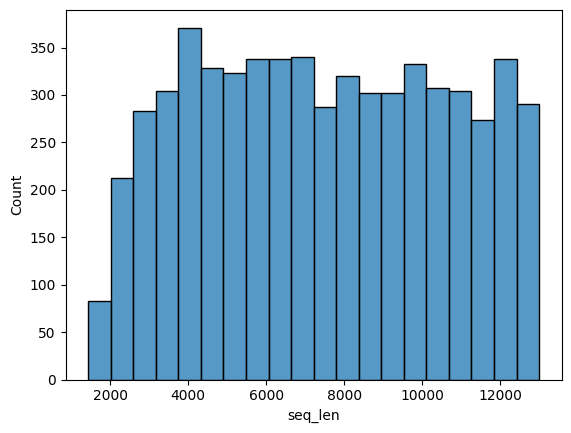

In [3]:
gene_df['seq_len'] = (gene_df['end']+gene_df['flank_right'])-(gene_df['start']-gene_df['flank_left'])  # length of each gene
gene_df['seq_len'] = (gene_df['end'])-(gene_df['start'])  # length of each gene

sns.histplot(gene_df['seq_len'])

In [4]:
gene_df['seq_len'].describe()

count     5977.000000
mean      7453.558140
std       3138.244325
min       1433.000000
25%       4760.000000
50%       7330.000000
75%      10159.000000
max      13000.000000
Name: seq_len, dtype: float64

In [53]:
gene_df['split'].value_counts()

split
train    4783
test      597
valid     597
Name: count, dtype: int64

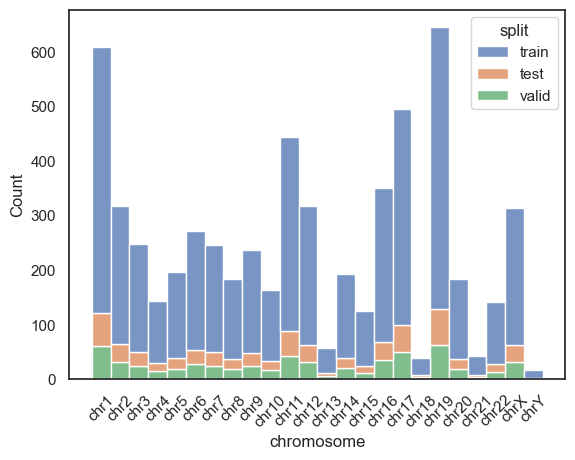

In [ ]:
chromosomes = [f"chr{idx}" for idx in range(1, 23)] + ["chrX", "chrY"]
plot_chr_in_splits(gene_df, chromosomes)

## Labels

In [20]:
labels_data = np.array(h5py.File(H5_FILE, 'r')['labels'])
labels_data


array([array([8., 8., 8., ..., 8., 8., 8.]),
       array([8., 8., 8., ..., 8., 8., 8.]),
       array([8., 8., 8., ..., 8., 8., 8.]), ...,
       array([8., 8., 8., ..., 8., 8., 8.]),
       array([8., 8., 8., ..., 8., 8., 8.]),
       array([8., 8., 8., ..., 8., 8., 8.])], dtype=object)

In [42]:
LABELS = ['E_F','D_F','I_F','A_F','E_R','D_R','I_R','A_R','NC']

def count_values(row):
    # Function to count values in a row
    values, counts = np.unique(row, return_counts=True)
    values = values.astype(int)
    
    row_labels = [LABELS[v] for v in values if v < len(LABELS)]

    if len(row_labels) > 0:
        for label in LABELS:
            if label not in row_labels:
                row_labels = np.append(row_labels, label)
                counts = np.append(counts, 0)

    return dict(zip(row_labels, counts))

vect_fun = np.vectorize(count_values)
result = vect_fun(labels_data).tolist()

labels_df = pd.DataFrame.from_records(result)
labels_df

,E_R,D_R,I_R,A_R,NC,E_F,D_F,I_F,A_F
0,1146,7,6795,7,1974,0,0,0,0
1,0,0,0,0,1422,366,1,595,1
2,0,0,0,0,1140,438,3,7079,3
3,0,0,0,0,1246,642,6,4667,6
4,0,0,0,0,7471,648,1,219,1
...,...,...,...,...,...,...,...,...,...
5972,0,0,0,0,1521,183,2,930,2
5973,0,0,0,0,1215,183,2,921,2
5974,0,0,0,0,1213,183,2,1022,2
5975,0,0,0,0,1210,183,2,922,2


/Users/dgreco2/miniconda3/envs/bend/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dgreco2/miniconda3/envs/bend/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


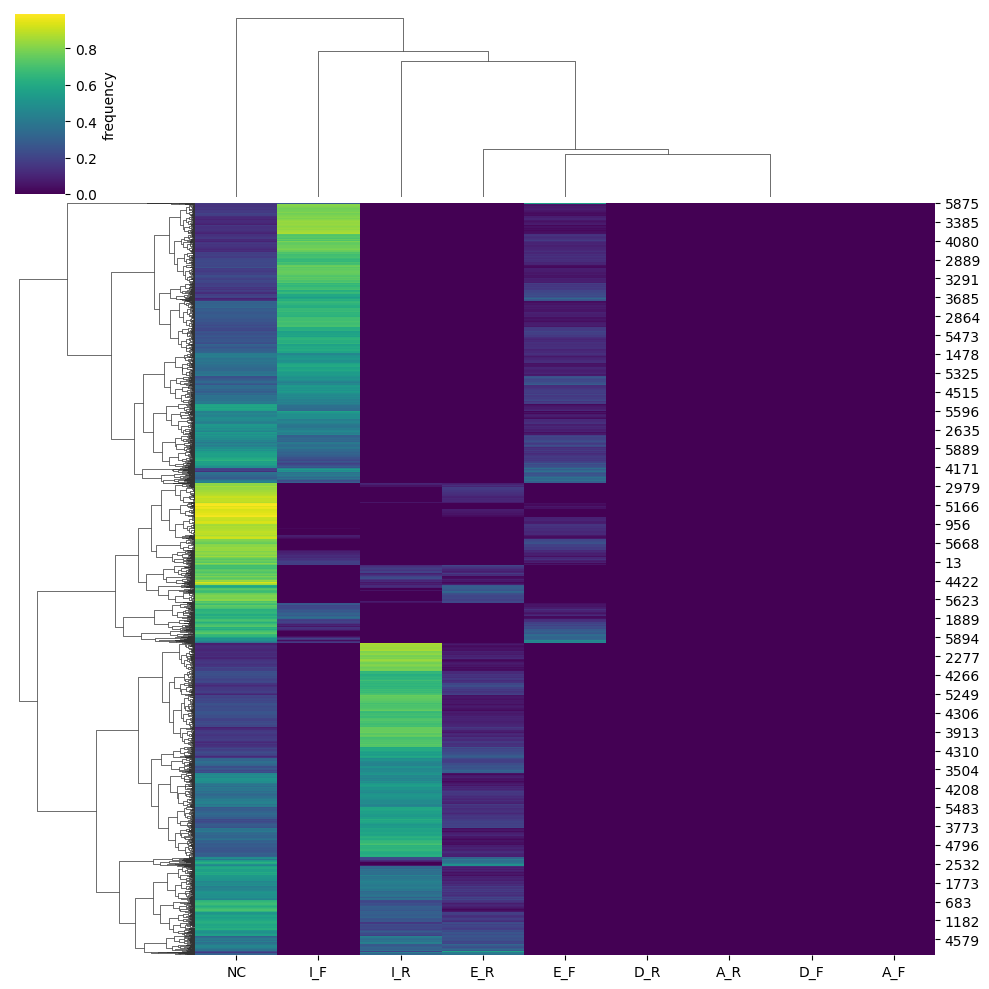

In [71]:
# check if the number of labels in each row matches the length of the gene
seq_len = labels_df.sum(axis=1)
assert (seq_len == gene_df['seq_len'].values).all()

labels_df_normalised = labels_df.div(seq_len, axis=0)
labels_df_normalised.fillna(0, inplace=True)
labels_df_normalised

sns.clustermap(labels_df_normalised, figsize=(10, 10), cmap='viridis', cbar_kws={'label': 'frequency'})